In [2]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from functools import partial

## Nexis

In [4]:

class run_Nexis:
    def __init__(self,C_,U_,t_vec_,w_dir_=0,volcorrect_=0,region_volumes_=[]):
        self.C = C_ # Connectivity matrix, nROI x nROI
        self.U = U_ # Matrix or vector of cell type or gene expression, nROI x nTypes
        self.t_vec = t_vec_ # Vector of time points to output model predictions, 1 x nt
        self.volcorrect = volcorrect_ # Binary flag indicating whether to use volume correction - ask ben 
        self.w_dir = w_dir_ # Binary flag indicating whether to use directionality or not 
        self.region_volumes = region_volumes_ # Array of region volumes, nROI x 1 if applicable
        
        if (datadir_==''):
            curdir = os.getcwd()
            subdir = 'raw_data_mouse'
            datadir_ = os.path.join(curdir,subdir)
        self.datadir = datadir_ # Directory to load dependences from

    def simulate_nexis(self, parameters):
        """
        Returns a matrix, Y, that is nROI x nt representing the modeled Nexis pathology
        given the provided parameters. alpha, beta, and gamma should be nonnegative scalars;
        s should be bounded between 0 and 1; b and p should be nCT-long vectors
        """
        # Define parameters
        ntypes = np.size(self.U,axis=1)
        alpha = parameters[0] # global connectome-independent growth (range [0,5])
        beta = parameters[1] # global diffusivity rate (range [0,5])
        gamma = parameters[2] # seed rescale value (range [0,10])
        if self.w_dir==0:
            s = 0.5
        else:
            s = parameters[3] # directionality (0 = anterograde, 1 = retrograde)
        b = np.transpose(parameters[4:(ntypes+4)]) # cell-type-dependent spread modifier (range [-5,5])
        p = np.transpose(parameters[(ntypes+4):6]) # cell-type-dependent growth modifier (range [-5,5]) #EDITED
        k = parameters[6] # Carrying capacity ADDED
        
        # Define starting pathology x0
        init_vec = parameters[7]
        init_vec = np.array(init_vec)
        x0 = gamma * init_vec
        
        # Define diagonal matrix Gamma containing spread-independent terms
        s_p = np.dot(self.U,p)
        Gamma = np.diag(s_p) + (alpha * np.eye(len(s_p))) 

        # Define Laplacian matrix L
        C_dir = (1-s) * np.transpose(self.C) + s * self.C
        coldegree = np.sum(C_dir,axis=0)
        L_raw = np.diag(coldegree) - C_dir
        s_b = np.dot(self.U,b)
        s_b = np.reshape(s_b,[len(s_b),1])
        S_b = np.tile(s_b,len(s_b)) + np.ones([len(s_b),len(s_b)])
        L = np.multiply(L_raw,np.transpose(S_b))

        # Apply volume correction if applicable
        if self.volcorrect:
            voxels_2hem = self.region_volumes

            inv_voxels_2hem = np.diag(np.squeeze(voxels_2hem).astype(float) ** (-1))
            
            L = np.mean(voxels_2hem) * np.dot(inv_voxels_2hem,L)

        # Define system dydt = Ax
        A = Gamma - (beta * L)

        # Solve 
        if self.version == 'logistic': # Run logistic forward model
            y = self.logistic(self.t_vec,x0,A,Gamma,k) 
            return y
        
        if self.version == 'exponential': # Run exponential forward model
            y = self.exponential(A,self.t_vec,x0)
            return y
        
        #else: # Run inverse model
            # x0 = self.inverse(A,self.t_vec,paramater)
            # return x0
    
    # Solve via analytic method (no logistic term)
    def exponential(self,A_,t_,x0_):
        y_ = np.zeros([np.shape(A_)[0],len(t_)])
        for i in list(range(len(t_))):
            ti = t_[i]
            y_[:,i] = np.dot(expm(A_*ti),np.squeeze(x0_)) 
        return y_
    
    # Solve via odeint with logistic term
    def logistic(self,t_,x0_,A_,Gamma_,k_):

        # Define ODE function with a logistic term
        def ode_func(y, t, A, Gamma, k):
            dydt = np.dot(A, y) - np.dot(Gamma,np.square(y)) / k
            return dydt

        # Initial condition
        y0 = x0_

        # Solve ODE using odeint
        sol = odeint(ode_func, y0, t_, args=(A_,Gamma_,k_))

        # Transpose so that sol is an array with dim nROI x time points
        sol = sol.T

        return sol
    
    #def inverse(self,t_,A_,Gamma,parameters):
        # ADD INVERSE MODEL HERE

## Preparing Inputs

In [6]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis 
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

In [7]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Converting region order of DK to that of connectivity matrix
new_order_DK = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order_DK, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

In [9]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1)) # Cell type matrix (nROI x nTypes)/ gene_data_reordered
t_vec_ = np.linspace(0, 18, 19)  # Time vector in terms of stages outputted by EBM (19 stages)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)

## Load Patient Data

In [10]:
# Upload patient data
patient_data = pandas.read_csv('Cross-sectional stage and regional tau.csv')

RID = 21 #EDIT PATIENT RID MANUALLY HERE
patient = patient_data[patient_data['RID'] == RID] 

# Define number of time points 
num_time_points = patient.shape[0]

# Define list with stage assingments for each time point
stages = patient['ml_stage'].tolist()
stages = [int(x) for x in stages]

# Define patient tau data
patient_tau = patient.iloc[:,3:]

# Reorder regions to match region order of connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
patient_tau = patient_tau.iloc[:, new_order_ADNI]

# Delete striatal regions 
patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

# Convert to array and transpose so dim = nROI x # of stages
patient_tau = patient_tau.to_numpy()
patient_tau = patient_tau.T

## Parameter Optimization

In [11]:
# SET LAMBDA HERE
l = 0.01

# Define a function that runs Nexis and calculates the MSE 
def Nexis_MSE(params, patient_tau):
        
        param1 = params # param1 = initial vector

        # Initialize run_Nexis class 
        nexis_model_mse = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                            volcorrect_=volcorrect_, region_volumes_=region_volumes_, logistic_term_ = logistic_term_, datadir_=datadir_)

        # Parameters for simulate_nexis method
        parameters = [0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07, 20.000567683872493, param1]  # [alpha, beta, gamma, s, b, p , k, inital vector] 

        # Call the simulate_nexis method with the parameters
        Y = nexis_model_mse.simulate_nexis(parameters)

        # For optimization, only take stages from Y that correspond to patient's stages 
        Y_edited = Y[:, stages] 

        error = mse_matrix(patient_tau,Y_edited) + l * param1.sum()
        
        return error

SyntaxError: invalid syntax (2458880979.py, line 2)

In [28]:
#Optimize parameters by minimizing MSE between patient data and Y
custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau)

# Initial guesses for initial vector
seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # Manually edit guess for seeding region here
seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]
array_length = nROI
init_guess = np.zeros(array_length)
init_guess[seeding_indices[0]] = 1 
init_guess[seeding_indices[1]] = 1

# Bounds for initial vector
bounds = [(0, 3) for _ in range(nROI)]

# Perform the optimization
result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B',
                      options={'ftol': 1e-6, 'gtol': 1e-6})

# Check the results
if result.success:
    optimized_initial_vec = result.x
    optimized_initial_vec = optimized_initial_vec.tolist( )
    print(f"Optimization successful. Optimized initial vector: {optimized_initial_vec}")
else:
    print("Optimization failed.", result.message)

Optimization successful. Optimized initial vector: [0.0, 0.0, 0.06556646176082769, 0.0, 0.0, 0.06351420657954267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03978175641680829, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3278659068763067, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7537967492417983, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Running Nexis

[[0.03460857 0.0605466  0.09596976 ... 5.41794696 6.55320008 7.79262828]
 [0.         0.06099809 0.1056579  ... 4.50774088 5.52896163 6.67848865]
 [0.39693363 0.32208775 0.29628163 ... 4.4413977  5.44521215 6.58063312]
 ...
 [0.         0.11427835 0.2210052  ... 5.11832514 6.1345212  7.26268059]
 [0.         0.09743408 0.2161418  ... 4.942434   5.95943597 7.09293496]
 [0.         0.08499811 0.16310222 ... 4.89126415 5.9124121  7.0507081 ]]


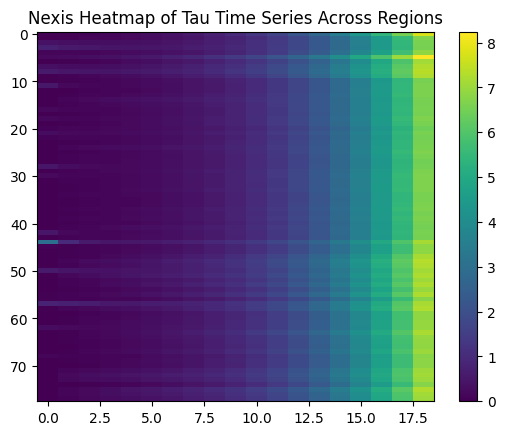

In [38]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_,
                        region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)

# Parameters for simulate_nexis method
parameters =  [0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07, 20.000567683872493, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE

# alpha = global coupling constant
# beta = diffusivity constant (0-5)
# gamma = seed rescale value 
# s = directionality constant 
# b = diffusivity modulated by cell type
# p = tau aggregation modulated by cell type

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

# Print resulting matrix (nROI x # of time points)
print(Y)

# Take stages from Y that correspond to patient's stages 
Y_edited = Y[:, stages]

# Plot heatmap of Y
plt = heatmap('baseline',Y)

## Check Results

In [39]:
# Calculate MSE between E(t) and Y
mse = mse_matrix(patient_tau, Y_edited)
print('Mean squared error: ' + str(mse))

Mean squared error: 0.03760806011137848


<function matplotlib.pyplot.show(close=None, block=None)>

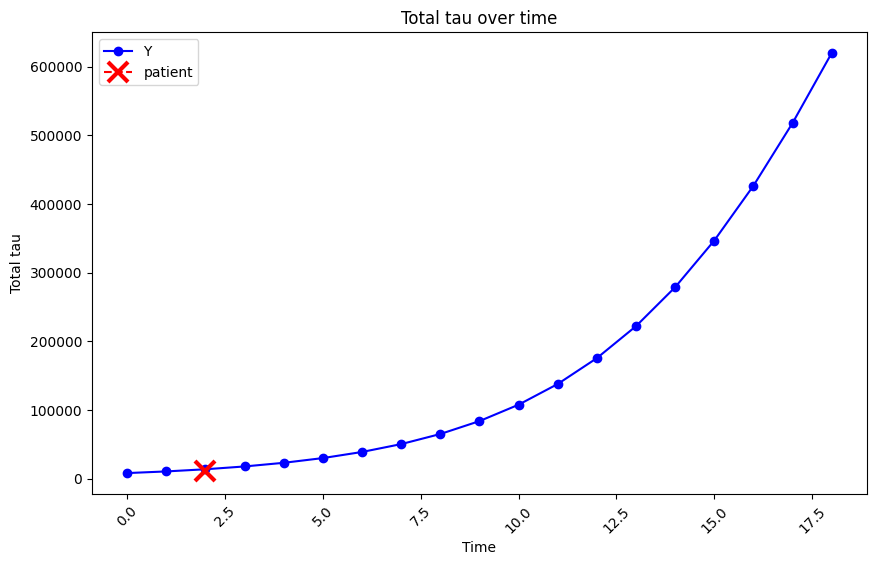

In [40]:
# Plot total tau over time to compare the scales of EBM and Y
# total_tau_Y = np.sum(Y, axis=0)
# total_tau_patient = np.sum(patient_tau, axis=0)

regional_volumes_array = np.array(regional_volumes_excluded)
regional_volumes_array = regional_volumes_array.reshape((78,1))
tau_mass_Y = regional_volumes_array * Y 
total_tau_Y = np.sum(tau_mass_Y, axis=0)
tau_mass_patient = regional_volumes_array * patient_tau
total_tau_patient = np.sum(tau_mass_patient, axis=0)

time_points_Y = np.linspace(0, 18, 19)

plt.figure(figsize=(10, 6))

# Plot total_tau_Y
plt.plot(time_points_Y, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

# Plot total_tau_patient on the same graph
plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='r', label= 'patient', markersize=15, markeredgewidth=3)

plt.title('Total tau over time') 
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Total tau')  # Label the y-axis
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.legend()  # Add a legend to distinguish the two lines

# Show the plot
plt.show

## Loop through all subjects

In [41]:
# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()

#Create a data frame for all patients seeding patterns
column_names = ['RID','ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate',	'ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal',	'ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala',	'Right-VentralDC']
seeding_all = pandas.DataFrame(columns=column_names)

for rid in unique_rids:

    patient = patient_data[patient_data['RID'] == rid] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    patient_tau = patient_tau.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # Perform the optimization
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau)

    result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B', 
                    options={'ftol': 1e-6, 'gtol': 1e-6})
    
    if result.success:
        optimized_initial_vec = result.x
        optimized_initial_vec = optimized_initial_vec.tolist( )
    
    # Create data frame for the subject
    seeding = pandas.DataFrame([[rid] + optimized_initial_vec], columns=column_names)

    # Concatenate the original DataFrame with the new DataFrame
    seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)

seeding_all

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_10896/771814580.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)


,RID,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,ctx-rh-entorhinal,ctx-rh-fusiform,ctx-rh-inferiorparietal,ctx-rh-inferiortemporal,ctx-rh-isthmuscingulate,...,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Hippocampus,Left-Amygdala,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Hippocampus,Right-Amygdala,Right-VentralDC
0,21,0.034609,0.00000,0.396934,0.739835,0.109436,0.203939,0.000000,0.341313,0.589438,...,0.100782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,31,0.000000,0.00000,0.000000,0.358090,0.000000,0.051544,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,56,0.000000,0.00000,0.000000,0.669913,0.000000,0.085726,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,59,0.006353,0.00000,0.349903,0.288115,0.000000,0.153350,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,69,0.131706,0.00000,0.411485,0.400093,0.270675,0.434303,0.003924,0.388804,0.404476,...,0.237063,0.122752,0.111021,0.093932,0.121115,0.163374,0.162657,0.028771,0.135576,0.050446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,6704,0.000000,0.00000,0.000000,0.179457,0.000000,0.087872,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.549741,0.000000
648,6705,0.000000,0.00000,0.000000,0.000000,0.000000,0.026761,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.062053,0.000000,0.000000,0.000000,0.083348,0.000000
649,6713,0.000000,0.00000,0.000000,0.000000,0.000000,0.048995,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
650,6721,0.000000,0.00000,0.000000,0.000079,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.216880,0.000000,0.000000,0.000000,0.065006,0.000000


In [42]:
# Save to a csv 
seeding_all.to_csv('Seeding patterns.csv')